In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [10]:
# Step 2: Load Data
customer_df = pd.read_csv(r"C:\Users\PRIME\OneDrive\Desktop\Zidio Project\3 Bank Customer Churn Prediction\customer_data.csv")
print("Customer Data:")
print(customer_df.head())

Customer Data:
   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure
0    15634602  Hargrave          619    France  Female   42       2
1    15647311      Hill          608     Spain  Female   41       1
2    15619304      Onio          502    France  Female   42       8
3    15701354      Boni          699    France  Female   39       1
4    15737888  Mitchell          850     Spain  Female   43       2


In [11]:
transaction_df = pd.read_csv(r"C:\Users\PRIME\OneDrive\Desktop\Zidio Project\3 Bank Customer Churn Prediction\transaction_data.csv")
print("\nTransaction Data:")
print(transaction_df.head())


Transaction Data:
   CustomerId    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0    15634602       0.00              1          1               1   
1    15647311   83807.86              1          0               1   
2    15619304  159660.80              3          1               0   
3    15701354       0.00              2          0               0   
4    15737888  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0  


In [14]:

#Adding Date column with random dates 
transaction_df['date'] = pd.to_datetime(
    np.random.choice(pd.date_range("2021-01-01", "2022-12-31", freq='D'), size=len(transaction_df))
)


In [29]:
transaction_df['date'] = pd.to_datetime(transaction_df['date'])
txn_summary = transaction_df.groupby('CustomerId').agg({
    'Balance': ['count', 'sum', 'mean']
})
txn_summary.columns = ['txn_count', 'total_spent', 'avg_spent']
txn_summary.reset_index(inplace=True)

# Merge into customer data
merged_df = customer_df.merge(txn_summary, on='CustomerId', how='left')

# Fill missing transaction data
merged_df[['txn_count', 'total_spent', 'avg_spent']] = merged_df[['txn_count', 'total_spent', 'avg_spent']].fillna(0)



In [34]:
# Handle numeric columns
numeric_cols = transaction_df.select_dtypes(include=['int64', 'float64']).columns
transaction_df[numeric_cols] = transaction_df[numeric_cols].fillna(transaction_df[numeric_cols].median())

# Handle categorical columns (only if they exist)
categorical_cols = transaction_df.select_dtypes(include='object').columns
if len(categorical_cols) > 0:
    transaction_df[categorical_cols] = transaction_df[categorical_cols].fillna(transaction_df[categorical_cols].mode().iloc[0])

# Encode categorical variables (if any)
transaction_df = pd.get_dummies(transaction_df, drop_first=True)


In [15]:
print(transaction_df.columns)

Index(['CustomerId', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'date'],
      dtype='object')


In [38]:
# --- Step 1: Purchase Frequency from transaction data ---

# Count transactions per customer
purchase_freq = transaction_df.groupby('CustomerId')['date'].count().reset_index()
purchase_freq.columns = ['CustomerId', 'purchase_frequency']

# --- Step 2: Engagement Score (you can define your own logic) ---
# Let's say engagement = total transactions * avg transaction amount
engagement = transaction_df.groupby('CustomerId').agg({
    'Balance': ['count', 'mean']
})
engagement.columns = ['txn_count', 'avg_amount']
engagement['engagement_score'] = engagement['txn_count'] * engagement['avg_amount']
engagement.reset_index(inplace=True)


# --- Step 4: Merge features into one DataFrame ---
# Merge all features on customer_id
features_df = customer_df.merge(purchase_freq, on='CustomerId', how='left')
features_df = features_df.merge(engagement[['CustomerId', 'engagement_score']], on='CustomerId', how='left')

# Fill NaN (customers with no transactions)
features_df['purchase_frequency'] = features_df['purchase_frequency'].fillna(0)
features_df['engagement_score'] = features_df['engagement_score'].fillna(0)


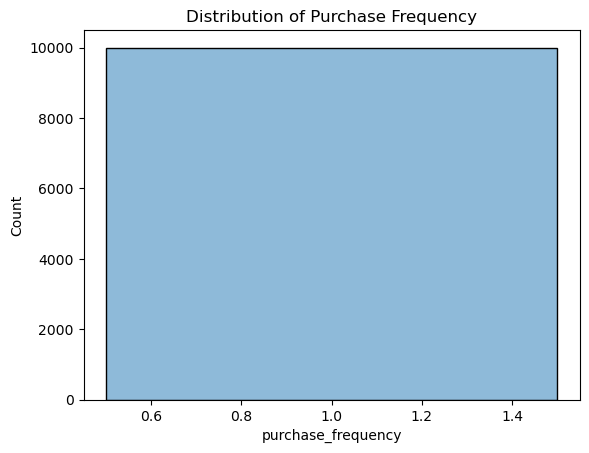

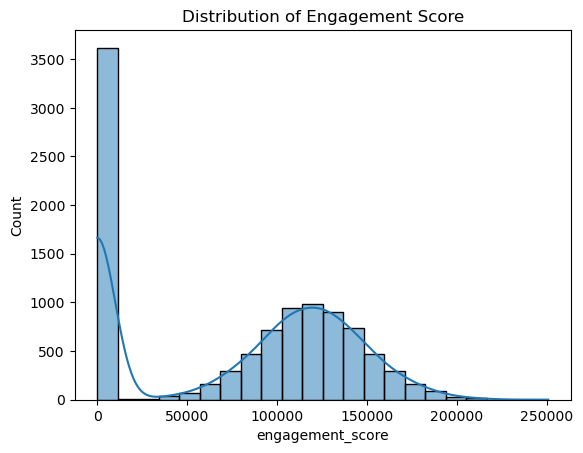

In [39]:
# Purchase Frequency distribution
sns.histplot(features_df['purchase_frequency'], kde=True)
plt.title("Distribution of Purchase Frequency")
plt.show()

# Engagement Score distribution
sns.histplot(features_df['engagement_score'], kde=True)
plt.title("Distribution of Engagement Score")
plt.show()

In [47]:
# Define features and target from your DataFrame
X = transaction_df.drop(columns=['Exited'])  # Target column
y = transaction_df['Exited']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
from sklearn.preprocessing import StandardScaler

#  Fix non-numeric column issues before scaling

# Drop all non-numeric columns (e.g., datetime, period, object)
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Drop them from both train and test sets
X_train = X_train.drop(columns=non_numeric_cols, errors='ignore')
X_test = X_test.drop(columns=non_numeric_cols, errors='ignore')

# Now scale safely
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [56]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [57]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[1607    0]
 [ 393    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000

Accuracy Score: 0.8035


C:\Users\PRIME\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PRIME\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PRIME\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#  Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

#  Predict
dt_pred = dt_model.predict(X_test_scaled)

#  Evaluation
print(" Decision Tree Classifier Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("\nClassification Report:\n", classification_report(y_test, dt_pred))
print("Accuracy Score:", accuracy_score(y_test, dt_pred))


 Decision Tree Classifier Results
Confusion Matrix:
 [[1326  281]
 [ 253  140]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1607
           1       0.33      0.36      0.34       393

    accuracy                           0.73      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.74      0.73      0.74      2000

Accuracy Score: 0.733


In [93]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
rf_pred = rf_model.predict(X_test_scaled)

# Evaluation
print("Random Forest Classifier Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))
print("Accuracy Score:", accuracy_score(y_test, rf_pred))


Random Forest Classifier Results
Confusion Matrix:
 [[1515   92]
 [ 298   95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1607
           1       0.51      0.24      0.33       393

    accuracy                           0.81      2000
   macro avg       0.67      0.59      0.61      2000
weighted avg       0.77      0.81      0.78      2000

Accuracy Score: 0.805


In [83]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#  Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test_scaled)

#  Evaluation
print("XGBoost Classifier Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))
print("Accuracy Score:", accuracy_score(y_test, xgb_pred))


C:\Users\PRIME\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Results
Confusion Matrix:
 [[1521   86]
 [ 293  100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      1607
           1       0.54      0.25      0.35       393

    accuracy                           0.81      2000
   macro avg       0.69      0.60      0.62      2000
weighted avg       0.78      0.81      0.78      2000

Accuracy Score: 0.8105


In [67]:
from sklearn.preprocessing import StandardScaler

# Select only features that exist in transaction_df
clustering_features = transaction_df[['Balance', 'EstimatedSalary', 'NumOfProducts', 'IsActiveMember']].copy()

# Fill missing values if any
clustering_features.fillna(0, inplace=True)

# Scale features
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_features)

In [73]:
from sklearn.cluster import KMeans

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(clustering_scaled)

# Create a new DataFrame to hold cluster assignments
cluster_df = clustering_features.copy()
cluster_df['cluster'] = cluster_labels
cluster_df['CustomerId'] = transaction_df['CustomerId'].values  # Ensure ID aligns

# Merge clusters into original transaction_df using customer_id
transaction_df = transaction_df.merge(cluster_df[['CustomerId', 'cluster']], on='CustomerId', how='left')

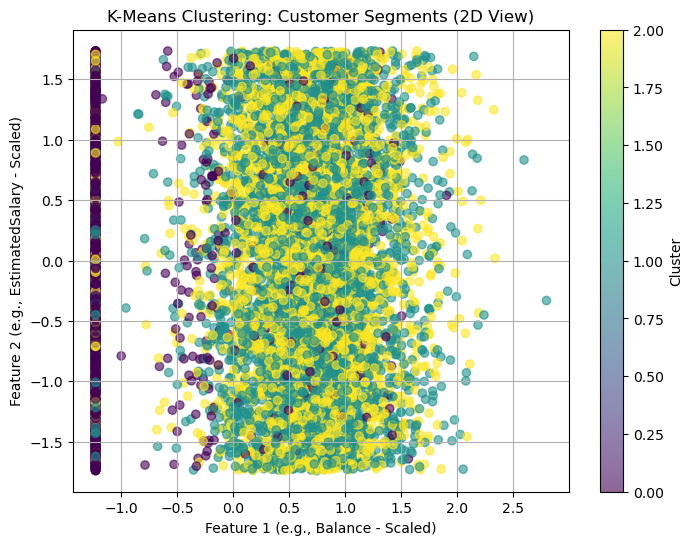

In [74]:
import matplotlib.pyplot as plt

# Plot using the first two scaled features
plt.figure(figsize=(8, 6))
plt.scatter(clustering_scaled[:, 0], clustering_scaled[:, 1], c=transaction_df['cluster'], cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering: Customer Segments (2D View)")
plt.xlabel("Feature 1 (e.g., Balance - Scaled)")
plt.ylabel("Feature 2 (e.g., EstimatedSalary - Scaled)")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

In [70]:
print("Clustering features shape:", clustering_features.shape)
print("Original transaction_df shape:", transaction_df.shape)

Clustering features shape: (10000, 4)
Original transaction_df shape: (10000, 9)


In [75]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Use the same scaled data used in KMeans
# (clustering_scaled from earlier step)

# DBSCAN model
dbscan = DBSCAN(eps=1.2, min_samples=5)  # adjust eps if needed
db_labels = dbscan.fit_predict(clustering_scaled)

# Add DBSCAN cluster labels to transaction_df
transaction_df['dbscan_cluster'] = db_labels

In [94]:
# Cluster counts (-1 means noise / anomalies)
print(" DBSCAN Cluster Counts (including noise):")
print(transaction_df['dbscan_cluster'].value_counts())

# Summary stats for non-noise clusters
print("\n DBSCAN Cluster Averages (excluding noise):")
cluster_summary = transaction_df[transaction_df['dbscan_cluster'] != -1].groupby('dbscan_cluster')[['Balance', 'EstimatedSalary', 'NumOfProducts']].mean()
print(cluster_summary)


 DBSCAN Cluster Counts (including noise):
dbscan_cluster
 0    2563
 5    2521
 3    2446
 2    2144
 1     153
 6     112
 4      25
 7      22
-1       9
 8       5
Name: count, dtype: int64

 DBSCAN Cluster Averages (excluding noise):
                      Balance  EstimatedSalary  NumOfProducts
dbscan_cluster                                               
0                98902.019317     98140.098513            1.0
1                79986.706667    103140.153137            3.0
2                51909.044380    100433.658158            2.0
3                51852.938729    100468.101292            2.0
4               117672.058000    105350.254800            4.0
5                98195.888413    100856.858921            1.0
6                67705.813304    106135.047321            3.0
7               121917.575000     97311.379091            4.0
8                    0.000000    119508.870000            4.0


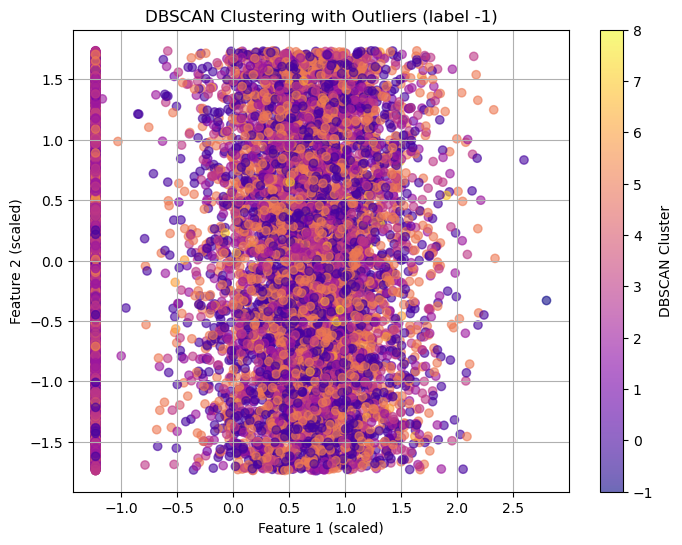

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(clustering_scaled[:, 0], clustering_scaled[:, 1], c=db_labels, cmap='plasma', alpha=0.6)
plt.title("DBSCAN Clustering with Outliers (label -1)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.grid(True)
plt.colorbar(label="DBSCAN Cluster")
plt.show()

In [78]:
import pandas as pd

# Ensure date is in datetime format
transaction_df['date'] = pd.to_datetime(transaction_df['date'])

# Create time-based columns
transaction_df['month'] = transaction_df['date'].dt.to_period('M')
transaction_df['quarter'] = transaction_df['date'].dt.to_period('Q')
transaction_df['year'] = transaction_df['date'].dt.year

In [81]:
import matplotlib.pyplot as plt

# Monthly Sales
monthly_sales = transaction_df.groupby('month')['Balance'].sum()

# Quarterly Sales
quarterly_sales = transaction_df.groupby('quarter')['Balance'].sum()

# Yearly Sales
yearly_sales = transaction_df.groupby('year')['Balance'].sum()

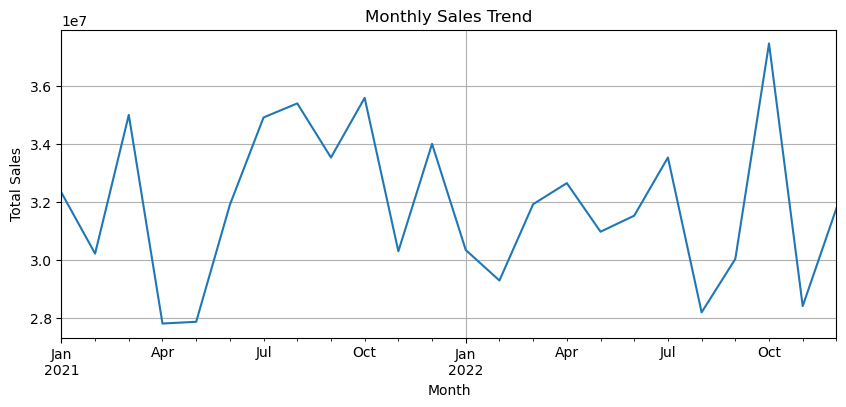

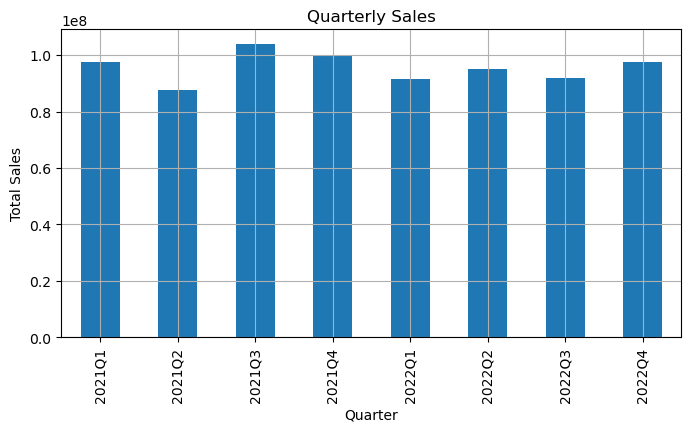

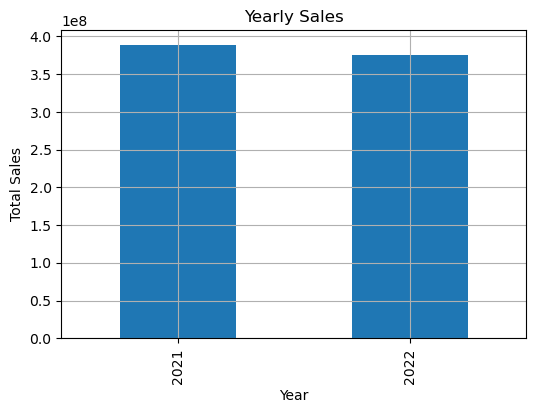

In [82]:


# Plot Monthly
monthly_sales.plot(kind='line', title="Monthly Sales Trend", figsize=(10, 4))
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

# Plot Quarterly
quarterly_sales.plot(kind='bar', title="Quarterly Sales", figsize=(8, 4))
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

# Plot Yearly
yearly_sales.plot(kind='bar', title="Yearly Sales", figsize=(6, 4))
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

In [92]:
# Export final data for Power BI
transaction_df.to_csv(r"C:\Users\PRIME\OneDrive\Desktop\Zidio Project\3 Bank Customer Churn Prediction\customer_churn_final.csv", index=False)
print("Data exported successfully as 'customer_churn_final.csv'")


Data exported successfully as 'customer_churn_final.csv'
